In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re 
import keras
from sklearn.preprocessing import OneHotEncoder

from PIL import Image
import cv2

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Dense, Dropout, Flatten, Activation
from keras import optimizers
from tensorflow.keras.optimizers import schedules
from keras.preprocessing.image import ImageDataGenerator

In [2]:
train_filenames = []
test_filenames = []

for filename in glob.iglob('train/*/*'):
    train_filenames.append(filename)
    
for filename in glob.iglob('test/*/*'):
    test_filenames.append(filename)

In [3]:
# preprocessing steps: 
# normalize values
# convert to grayscale
# create augmented data in an imagedatagenerator
# 
# transfer learning perhaps
# CNN with last layer being softmax

In [4]:
train_images = []
train_labels = []

test_images = []
test_labels = []

for filename in train_filenames:
    image = cv2.imread(filename)
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # gray = gray / 255
    # train_images.append(gray)
    image = image / 255
    train_images.append(image)
        
    label = re.search('(?<=\\\)([a-z]+)(?=\\\)', filename).group(0)
    train_labels.append(label)
    
for filename in test_filenames:
    image = cv2.imread(filename)
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  
    #gray = gray / 255
    #test_images.append(gray)
    image = image / 255
    test_images.append(image)
    
    label = re.search('(?<=\\\)([a-z]+)(?=\\\)', filename).group(0)
    test_labels.append(label)
    
train_images = np.array(train_images)
test_images = np.array(test_images)

In [5]:
num_classes = 7

onehot_encoder = OneHotEncoder(sparse=False)

train_labels = onehot_encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
test_labels = onehot_encoder.fit_transform(np.array(test_labels).reshape(-1, 1))

### Randomly shuffle the train and test images and simultaneously shuffle the respective labels in unison

In [6]:
p1 = np.random.permutation(len(train_images))
train_images = train_images[p1]
train_labels = train_labels[p1]

p2 = np.random.permutation(len(test_images))
test_images = test_images[p2]
test_labels = test_labels[p2]

In [7]:
#cv2.imshow('img', train_images[0])

#cv2.waitKey(0)
#cv2.destroyAllWindows()

model = Sequential()

model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, kernel_size=5, activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(train_images, train_labels, validation_split=0.2, batch_size=128, epochs=100)

scores = model.evaluate(test_images, test_labels, batch_size=128)
print("Accuracy: %.2f%%" % (scores[1]*100))

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(hist.history['accuracy'], ls='dashed')
ax.set_xlabel("epochs")
ax.plot(hist.history['val_' + 'accuracy'])

In [8]:
### Attempting to improve accuracy below via two tries
# Try 1 is augmenting dataset
# Try 2 is using transfer learning

datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

it_train = datagen.flow(train_images, train_labels, batch_size=64, subset='training')
it_val = datagen.flow(train_images, train_labels, batch_size=16, subset='validation')

In [77]:
from keras.applications.vgg19 import VGG19

vgg_model = VGG19(include_top=False, input_shape=[48, 48, 3])
#vgg_model.trainable = False

model = Sequential([
    vgg_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_10 (Flatten)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 512)               262656    
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               65664     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 7)               

In [78]:
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    staircase=True,
    decay_rate=0.1)

In [ ]:
#opt = optimizers.Adam(learning_rate=0.0001)
opt = optimizers.RMSprop(learning_rate=0.0001, decay=0.0001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_images, train_labels, validation_split=0.2, batch_size=128, epochs=10)

Epoch 1/10
180/180 [==============================] - 2618s 15s/step - loss: 0.1183 - accuracy: 0.9673 - val_loss: 2.3866 - val_accuracy: 0.6266
Epoch 2/10
180/180 [==============================] - 1357s 8s/step - loss: 0.0922 - accuracy: 0.9742 - val_loss: 2.4773 - val_accuracy: 0.6308
Epoch 3/10
180/180 [==============================] - 1330s 7s/step - loss: 0.0848 - accuracy: 0.9761 - val_loss: 2.4052 - val_accuracy: 0.6294
Epoch 4/10
180/180 [==============================] - 1323s 7s/step - loss: 0.0758 - accuracy: 0.9787 - val_loss: 2.7297 - val_accuracy: 0.6249
Epoch 5/10
180/180 [==============================] - 1325s 7s/step - loss: 0.0726 - accuracy: 0.9808 - val_loss: 2.5897 - val_accuracy: 0.6224
Epoch 6/10
 80/180 [============>.................] - ETA: 11:47 - loss: 0.0659 - accuracy: 0.9826

In [81]:
scores = model.evaluate(test_images, test_labels, batch_size=128)
print("Accuracy: %.2f%%" % (scores[1]*100))

57/57 [==============================] - 101s 2s/step - loss: 2.0332 - accuracy: 0.6170
Accuracy: 61.70%


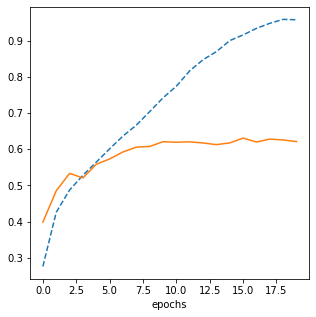

In [82]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(hist.history['accuracy'], ls='dashed')
ax.set_xlabel("epochs")
ax.plot(hist.history['val_' + 'accuracy'])

In [ ]:
test_img_fn = ""

test_image = cv2.imread(test_img_fn)
test_image = test_image.reshape(48, 48, 3)
test_image = test_image / 255

model.predict(test_image)